In [1]:
import pandas as pd
import sys
from pathlib import Path
import pastas as ps

# Add the 'scripts' directory to sys.path
scripts_path = Path("../scripts").resolve()
if str(scripts_path) not in sys.path:
    sys.path.append(str(scripts_path))


### Loading Input Files

In [2]:
from knmi_pull import fetch_knmi_prec_evap
data = fetch_knmi_prec_evap("249", "2000-01-01", "2025-06-01")

In [3]:
prec = data[0]
evap = data[1]

In [4]:
# 1. Load Excel file
file_path_excel = Path("../input_files/input_single/13_7_HB21_PB1.xlsx")
df_head = pd.read_excel(file_path_excel)

print(df_head.head())

             DateTime  HB28_PB1
0 2023-11-10 00:00:00       NaN
1 2023-11-10 01:00:00       NaN
2 2023-11-10 02:00:00       NaN
3 2023-11-10 03:00:00       NaN
4 2023-11-10 04:00:00       NaN


In [5]:
# 2. Convert 'time' column to datetime using flexible parsing
df_head['time'] = pd.to_datetime(df_head['DateTime'], format='mixed', dayfirst=True)

# 3. Set datetime column as index
df_head.set_index('time', inplace=True)

# 4. Resample to daily mean
head_daily_mean = df_head['HB28_PB1'].resample("D").mean().dropna()

#### Waterhoogte systeem

In [6]:
# 1. Load Excel file
file_path_waterhoogte = Path("../input_files/input_single/waterhoogte_drieban.xlsx")
df = pd.read_excel(file_path_waterhoogte)

# 2. Convert 'datetime' column to datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

# 3. Set datetime as index
df.set_index('datetime', inplace=True)

# 4. Resample to daily mean (will have missing dates if no data on some days)
waterhoogte_daily_mean = df['waterhoogte'].resample("D").mean()

# 5. Fill missing days with a method or value, e.g., forward fill or zero (if appropriate)
waterhoogte_daily_mean = waterhoogte_daily_mean.ffill()  # or .bfill(), or .fillna(0)

# 6. Now frequency can be inferred correctly
waterhoogte_daily_mean.index.freq = "D"

### Gegevenscontrole

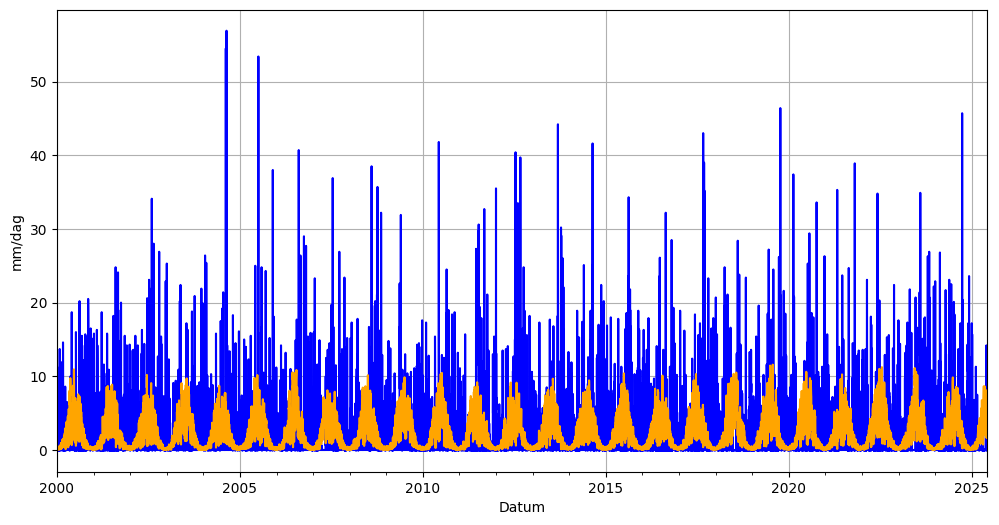

In [7]:
import matplotlib.pyplot as plt

ax1 = prec.plot(label='Precipitation', color='blue', figsize=(12, 6))
ax2 = evap.plot(label='Evaporation', color='orange')
plt.xlabel("Datum")
plt.ylabel("mm/dag")  # or your preferred unit
plt.grid(True)
plt.show()

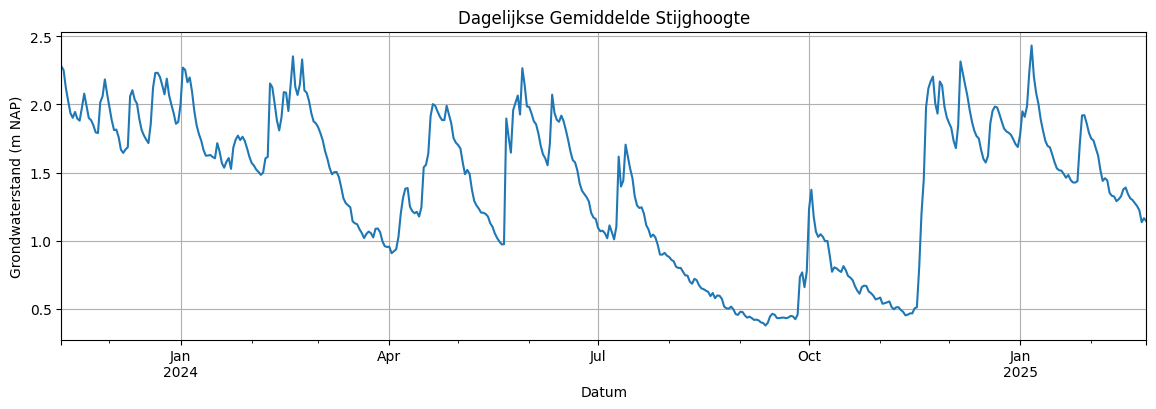

In [8]:
head_daily_mean.plot(figsize=(14, 4), title="Dagelijkse Gemiddelde Stijghoogte")
plt.xlabel("Datum")
plt.ylabel("Grondwaterstand (m NAP)")  # or your preferred unit
plt.grid(True)
plt.show()


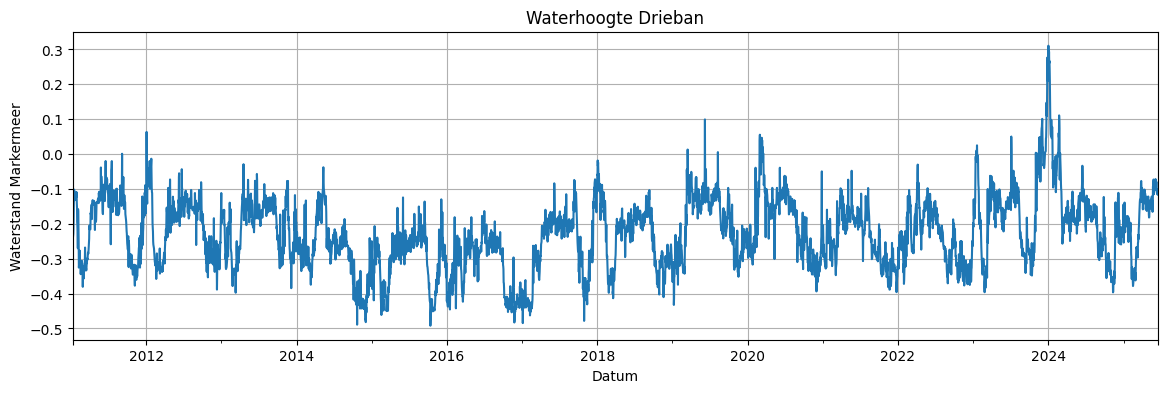

In [9]:
waterhoogte_daily_mean.plot(figsize=(14, 4), title="Waterhoogte Drieban")
plt.xlabel("Datum")
plt.ylabel("Waterstand Markermeer")  # or your preferred unit
plt.grid(True)
plt.show()


In [10]:
start_head_series = head_daily_mean.index.min()
end_head_series = head_daily_mean.index.max()

print(start_head_series, end_head_series)

2023-11-10 00:00:00 2025-02-25 00:00:00


In [11]:
import plotly.graph_objects as go

# Align all series to the index of head_daily_mean
common_index = head_daily_mean.dropna().index
prec_aligned = prec.reindex(common_index).fillna(0)
evap_aligned = evap.reindex(common_index).fillna(0)
waterhoogte_aligned = waterhoogte_daily_mean.reindex(common_index).fillna(method="ffill")

fig = go.Figure()

# Precipitation
fig.add_trace(go.Scatter(
    x=common_index, y=prec_aligned,
    mode='lines', name='Precipitation (mm/dag)',
    yaxis='y2', line=dict(color='blue')
))

# Evaporation
fig.add_trace(go.Scatter(
    x=common_index, y=evap_aligned,
    mode='lines', name='Evaporation (mm/dag)',
    yaxis='y2', line=dict(color='orange')
))

# Groundwater head
fig.add_trace(go.Scatter(
    x=common_index, y=head_daily_mean.reindex(common_index),
    mode='lines', name='Stijghoogte (m NAP)',
    yaxis='y1', line=dict(color='green')
))

# Surface water level
fig.add_trace(go.Scatter(
    x=common_index, y=waterhoogte_aligned,
    mode='lines', name='Waterhoogte Markermeer',
    yaxis='y1', line=dict(color='purple')
))

# Layout
fig.update_layout(
    title="Meteorologische en Hydrologische Tijdreeksen",
    xaxis=dict(title='Datum'),
    yaxis=dict(title='Grondwater- en Waterstand (m NAP)', side='left'),
    yaxis2=dict(title='Neerslag en Verdamping (mm/dag)', overlaying='y', side='right'),
    legend=dict(x=0.01, y=0.99),
    height=500,
    width=1000
)

fig.show()


Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

### Model neerzetten

c:\Users\jvanruitenbeek\AppData\Local\pypoetry\Cache\virtualenvs\pastas-wv2030-DEhQJ0k--py3.12\Lib\site-packages\pastas\rfunc.py:1281: IntegrationWarning:

The integral is probably divergent, or slowly convergent.

c:\Users\jvanruitenbeek\AppData\Local\pypoetry\Cache\virtualenvs\pastas-wv2030-DEhQJ0k--py3.12\Lib\site-packages\pastas\rfunc.py:1336: IntegrationWarning:

The integral is probably divergent, or slowly convergent.



Fit report NonlinearRechargeModel Fit Statistics
nfev    230                    EVP         83.12
nobs    474                    R2           0.83
noise   True                   RMSE         0.22
tmin    2023-11-10 00:00:00    AICc     -2194.56
tmax    2025-02-25 00:00:00    BIC      -2149.36
freq    D                      Obj          2.20
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (11 optimized)
                 optimal    initial  vary
rch_A           6.606598   0.174630  True
rch_alpha       0.929840   0.100000  True
rch_a1         53.417362  10.000000  True
rch_a2       4999.999986  10.000000  True
rch_f          -0.567839  -1.000000  True
extra_A         0.074104   9.805271  True
extra_n       -10.000000   1.000000  True
extra_a        84.680845  10.000000  True
extra_b        25.000000  10.000000  True
constant_d     -2.581302   1.408101  True
noise_alpha     9.637905   1.000000  True

Warnings! (7)
Parameter 'rc

[<Axes: xlabel='time', ylabel='Head'>,
 <Axes: xlabel='time'>,
 <Axes: title={'right': "Stresses: ['Precipitation', 'ET']"}, xlabel='DATE', ylabel='Rise'>,
 <Axes: title={'center': 'Step response'}, xlabel='Time [days]'>,
 <Axes: title={'right': "Stresses: ['waterhoogte']"}, xlabel='datetime', ylabel='Rise'>,
 <Axes: title={'center': 'Step response'}, xlabel='Time [days]'>,
 <Axes: title={'left': 'Model Parameters ($n_c$=11)'}>]

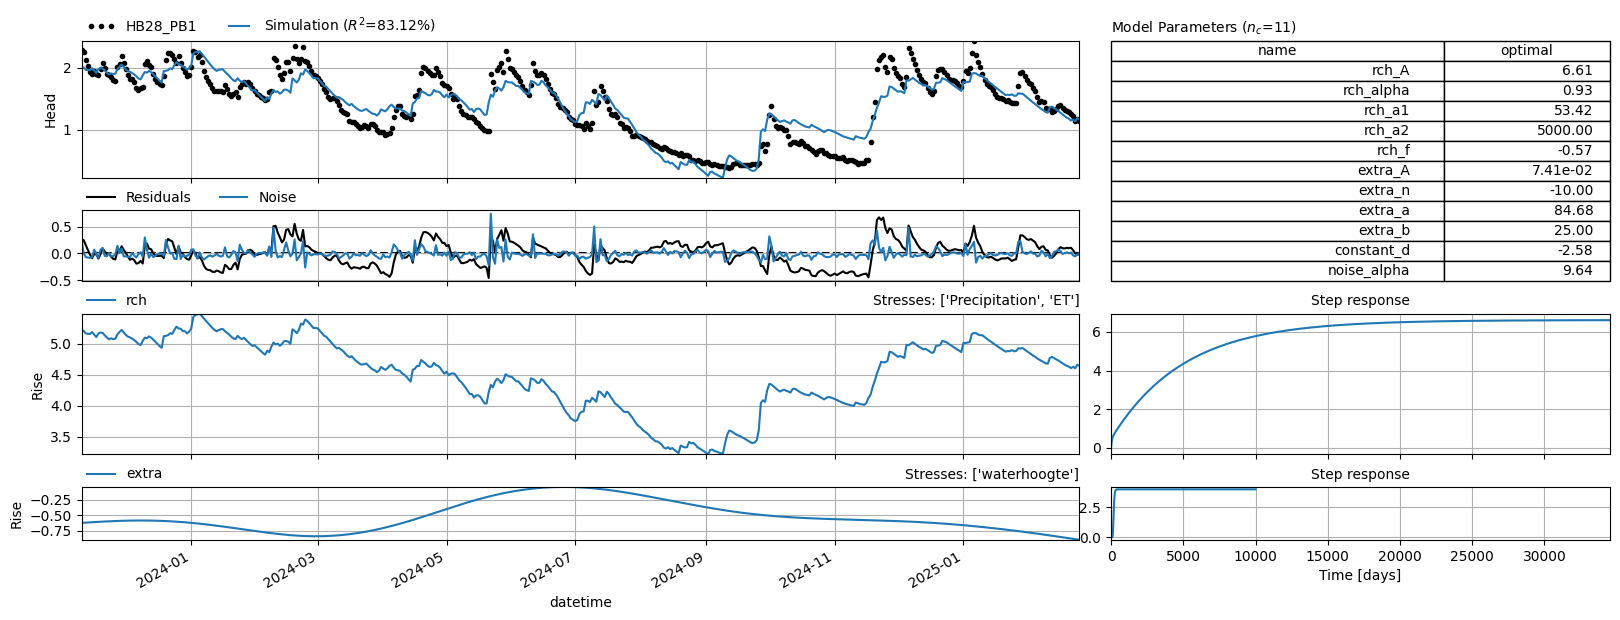

In [12]:
# 1. Create the model
ml = ps.Model(head_daily_mean, name="NonlinearRechargeModel")

# 2. Define recharge model
rch = ps.rch.Linear()  # Nonlinear recharge function
rm = ps.RechargeModel(
    prec=prec,
    evap=evap,
    recharge=rch,
    rfunc=ps.DoubleExponential(),  # Response function
    name="rch"
)
ml.add_stressmodel(rm)

# # # Optional: add extra stressor if needed
extra = ps.StressModel(waterhoogte_daily_mean, rfunc=ps.FourParam(), name="extra", settings="prec", up=True)
ml.add_stressmodel(extra)


#3. Add noise model explicitly (e.g., AR(1))
noise_model = ps.ArNoiseModel(2)  # You can specify order with ps.ArNoiseModel(order=2), etc.
ml.add_noisemodel(noise_model)

# 4. Solve the model
ml.solve(tmin=start_head_series, tmax=end_head_series, solver=ps.LeastSquares(), report=True)

# 5. Plot results
ml.plots.results(figsize=(16, 6))

[<Axes: xlabel='Simulated values', ylabel='Residuals'>,
 <Axes: xlabel='Simulated values', ylabel='$\\sqrt{|Residuals|}$'>,
 <Axes: title={'center': 'Noise (n=473, $\\mu$=-0.00)'}, xlabel='time', ylabel='Noise'>,
 <Axes: title={'center': 'Histogram'}, ylabel='Probability density'>,
 <Axes: xlabel='Lag [Days]', ylabel='Autocorrelation [-]'>,
 <Axes: title={'center': 'Probability Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered Values'>]

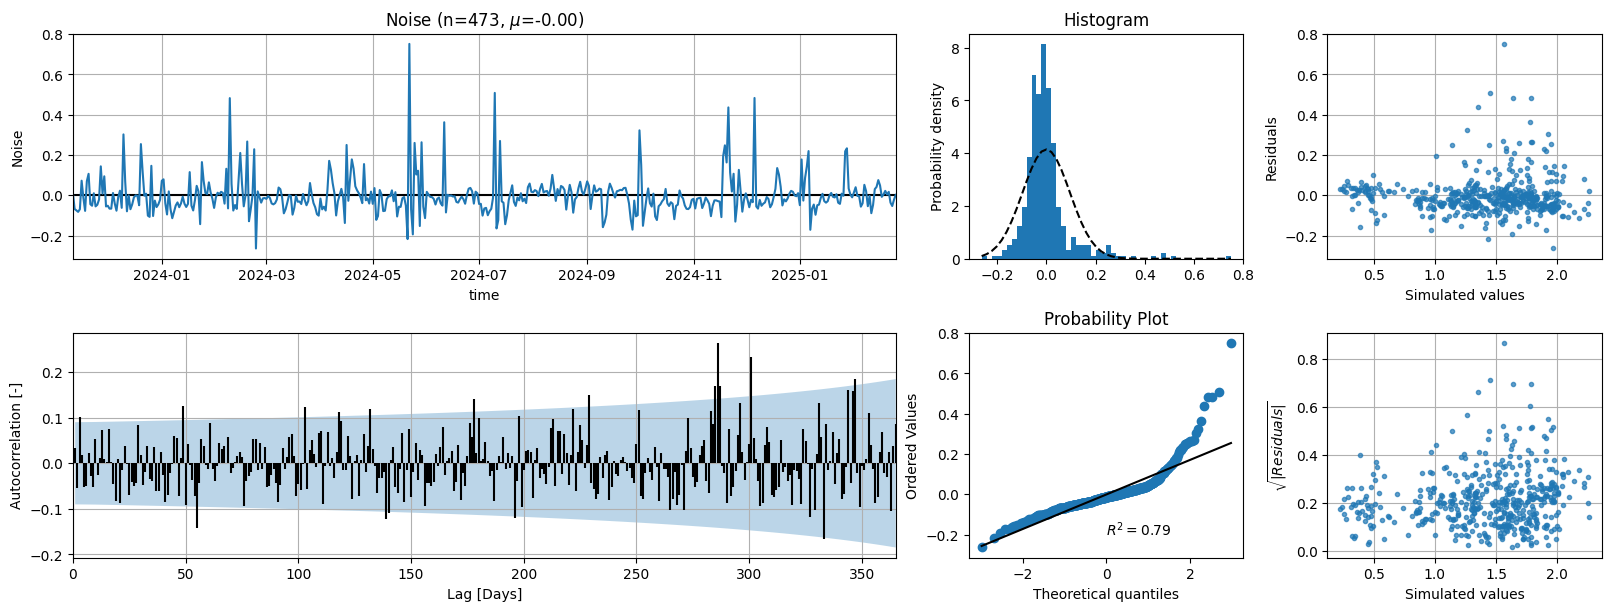

In [13]:
ml.plots.diagnostics(figsize=(16, 6))

array([<Axes: xlabel='time', ylabel='Head'>,
       <Axes: title={'center': 'rch (Precipitation)'}, xlabel='DATE', ylabel='Rise'>,
       <Axes: title={'center': 'rch (ET)'}, xlabel='DATE', ylabel='Rise'>,
       <Axes: title={'center': 'extra'}, xlabel='datetime', ylabel='Rise'>],
      dtype=object)

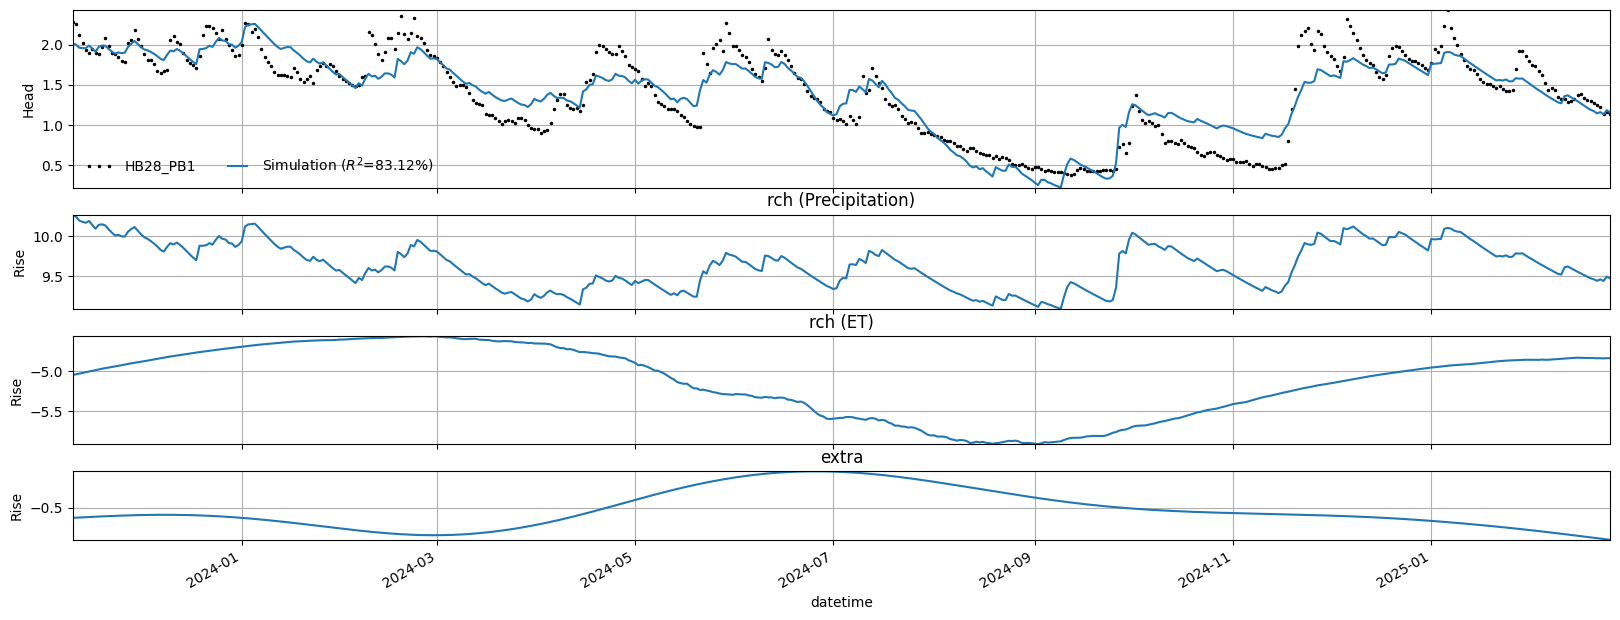

In [14]:
ml.plots.decomposition(figsize=(16, 6))

In [15]:
print(ml.stats.diagnostics(alpha=0.05))

                  Checks Statistic P-value  Reject H0 ($\alpha$=0.05)
Shapiroo       Normality      0.79    0.00                       True
D'Agostino     Normality    301.89    0.00                       True
Runs test      Autocorr.     -6.16    0.00                       True
Ljung-Box      Autocorr.     15.82    0.32                      False
Durbin-Watson  Autocorr.      1.93     nan                      False


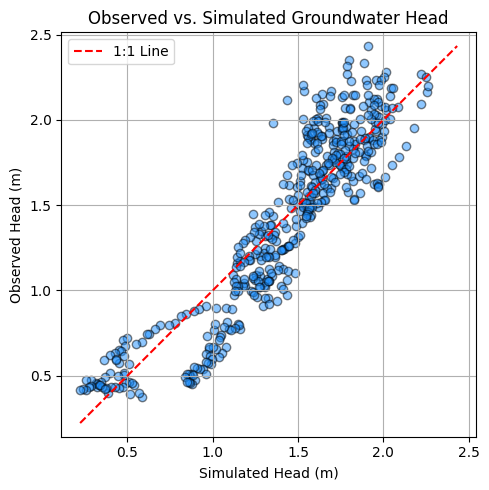

In [16]:
import matplotlib.pyplot as plt

# Get observed and simulated values
observed = ml.observations()  # <- no .series here!
simulated = ml.simulate()

# Create scatter plot
plt.figure(figsize=(5, 5))
plt.scatter(simulated, observed, alpha=0.5, color='dodgerblue', edgecolor='k')

# Add 45-degree reference line
min_val = min(observed.min(), simulated.min())
max_val = max(observed.max(), simulated.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="1:1 Line")

# Labels and title
plt.xlabel("Simulated Head (m)")
plt.ylabel("Observed Head (m)")
plt.title("Observed vs. Simulated Groundwater Head")
plt.grid(True)
plt.legend()
plt.axis("equal")
plt.tight_layout()
plt.show()


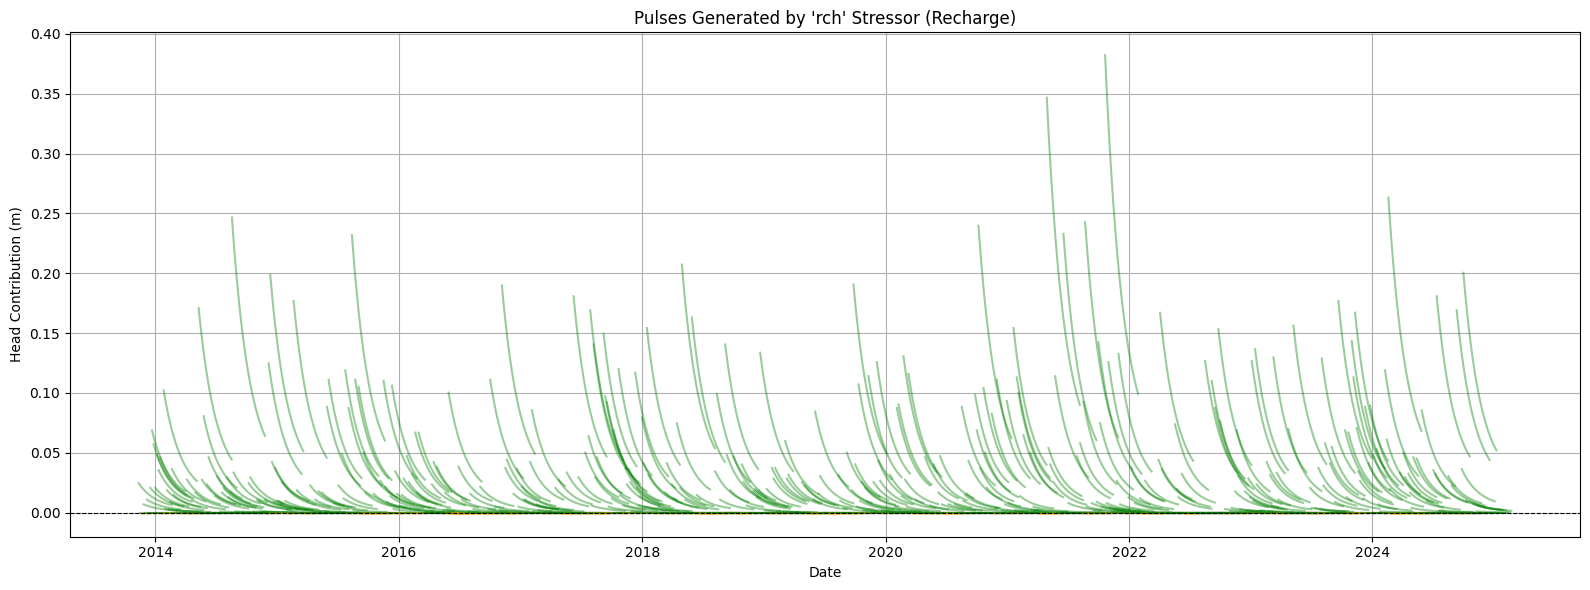

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Get the recharge input series (already includes prec, evap, and recharge logic)
recharge_input = ml.stressmodels['rch'].stress[0].series.asfreq("D").fillna(0)

# 2. Get parameters from the model
all_params_df = ml.parameters  # this is a DataFrame in all versions
rch_param_names = [p for p in all_params_df.index if p.startswith("rch_")]
rch_param_values = all_params_df.loc[rch_param_names, "optimal"].values

# 3. Get the response function object
rch_rfunc = ml.stressmodels['rch'].rfunc

# 4. Compute the IRF and truncate
full_irf_rch = rch_rfunc.block(rch_param_values, dt=1.0)
cutoff = 100
irf_rch = full_irf_rch[:cutoff]

# 5. Prepare plotting loop
dates = recharge_input.index
n = len(recharge_input)

plt.figure(figsize=(16, 6))

for i in range(0, n - cutoff, 5):  # step=5 to reduce clutter
    t0 = dates[i]
    t_range = pd.date_range(t0, periods=cutoff, freq="D")
    pulse = recharge_input.iloc[i] * irf_rch
    plt.plot(t_range, pulse, color='green' if pulse[0] >= 0 else 'orange', alpha=0.4)

plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title("Pulses Generated by 'rch' Stressor (Recharge)")
plt.xlabel("Date")
plt.ylabel("Head Contribution (m)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Get stress input
stress_input = ml.stressmodels['extra'].stress[0].series.asfreq("D").fillna(0)

# 2. Get impulse response function (IRF), truncate
full_irf = ps.FourParam().block([A, a, b, c], dt=1.0)
cutoff = 100
irf = full_irf[:cutoff]

# 3. Prepare time values
dates = stress_input.index
n = len(stress_input)

# 4. Plot
plt.figure(figsize=(16, 6))

for i in range(0, n - cutoff, 5):  # step=5 to avoid overplotting (adjust as needed)
    t0 = dates[i]
    t_range = pd.date_range(t0, periods=cutoff, freq="D")
    pulse = stress_input.iloc[i] * irf
    plt.plot(t_range, pulse, color='blue' if pulse[0] >= 0 else 'red', alpha=0.5)

plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title("Pulses Generated by 'extra' Stressor (Colored by Sign)")
plt.xlabel("Date")
plt.ylabel("Head Contribution (m)")
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'A' is not defined

In [ ]:
results_df